# Analysis Report
## Files
setC.csv = data obtained from the blocking stage  
sampleA.csv = 800 rows that are sample with (seed = 10) from setC

In [1]:
import csv

setC = None
with open('labelled.csv', 'r') as file:
    setA = list(csv.reader(file))
    setA = setA[1:] # Remove header
    setB = setA[375:] # Evaluation set
    setA = setA[:375] # Development set

class attr:
    label = 0
    _id = 1
    ltable_Id = 2
    rtable_Id = 3
    ltable_Title = 4
    ltable_Category = 5
    ltable_Duration = 6
    ltable_Rating = 7
    ltable_Rating_Count = 8
    ltable_Director = 9 
    rtable_Title = 10
    rtable_Category = 11
    rtable_Duration = 12
    rtable_Rating = 13
    rtable_Rating_Count = 14
    rtable_Director = 15
    strings = ['label', '_id', 'ltable_Id', 'rtable_Id', 'ltable_Title', 'ltable_Category', 
               'ltable_Duration', 'ltable_Rating', 'ltable_Rating_Count', 'ltable_Director', 
               'rtable_Title', 'rtable_Category', 'rtable_Duration', 'rtable_Rating', 'rtable_Rating_Count',
               'rtable_Director']

In [2]:
# Calculate number of null value for each attributes
def check_null(setx):
    num_null = [0 for i in range(16)]
    
    for row in setx:
        for pos, val in enumerate(row):
            if not val:
                num_null[pos] += 1
    
    for pos, val in enumerate(num_null):
        print(attr.strings[pos] + ": " + str(val))

In [3]:
# Define a function that scan the whole table and remove null value based on pos
def fill_null(setx, pos, val):
    for row in setx:
        if not row[pos]:
            row[pos] = val

In [4]:
# Values with null item, size of setA = 800
# print("SetA")
# check_null(setA)
fill_null(setA, attr.ltable_Rating, 0)
fill_null(setA, attr.rtable_Rating, 0)
fill_null(setA, attr.ltable_Duration, 0)
fill_null(setA, attr.rtable_Duration, 0)
fill_null(setA, attr.ltable_Rating_Count, 0)
fill_null(setA, attr.rtable_Rating_Count, 0)
# print("SetB")
# check_null(setB)
fill_null(setB, attr.ltable_Rating, 0)
fill_null(setB, attr.rtable_Rating, 0)
fill_null(setB, attr.ltable_Duration, 0)
fill_null(setB, attr.rtable_Duration, 0)
fill_null(setB, attr.ltable_Rating_Count, 0)
fill_null(setB, attr.rtable_Rating_Count, 0)

## Begin Matching
Start by converting each labelled row into a feature vector

In [57]:
from sklearn import tree, ensemble, linear_model, svm, naive_bayes
from sklearn.model_selection import KFold
from py_stringmatching.tokenizer.delimiter_tokenizer import DelimiterTokenizer
from py_stringmatching.similarity_measure.levenshtein import Levenshtein

delim_tkn = DelimiterTokenizer()
lev = Levenshtein()

class_group = ['d', 'l', 'r', 's', 'n']
names = {'d':'DECISION TREE', 'l':'LOGISTIC REGRESSION', 'r':'RANDOM FOREST', 's':'SUPPORT VECTOR MACHING', 'n':'NAIVE BAYES'}

In [6]:
def title_match(x, y):
    return lev.get_raw_score(x, y)

def category_match(x, y):
    return lev.get_raw_score(x, y)
    
def rating_match(x, y):
    return abs(float(x) - float(y))
    
def director_match(x, y):
    return lev.get_raw_score(x, y)

def rating_count_match(x, y):
    return abs(float(x) - float(y))

def duration_match(x, y):
    return abs(float(x) - float(y))

In [7]:
# Given a set, return the feature vectors and label
def get_feature(setx):
    feature = []
    label = []
    
    for row in setx:
        label += [row[attr.label]]
        
        x_0 = title_match(row[attr.ltable_Title], row[attr.rtable_Title])
        x_1 = category_match(row[attr.ltable_Category], row[attr.rtable_Category])
        x_2 = rating_match(row[attr.ltable_Rating], row[attr.rtable_Rating])
        x_3 = director_match(row[attr.ltable_Director], row[attr.rtable_Director])
        x_4 = duration_match(row[attr.ltable_Duration], row[attr.rtable_Duration])
        x_5 = rating_count_match(row[attr.ltable_Rating_Count], row[attr.rtable_Rating_Count])
        
        feature += [[x_0, x_1, x_2, x_3]]
        
    return feature, label
    

In [8]:
def get_ltable(setx):
    return [[row[attr.ltable_Id]] + row[attr.ltable_Title:attr.ltable_Director + 1]for row in setx]

def get_rtable(setx):
    return [[row[attr.rtable_Id]] + row[attr.rtable_Title:]for row in setx]

def get_label(setx):
    return [row[attr.label] for row in setx]

In [9]:
# Given a list of real result and predicted result, calculate precision, recall and F1
def get_F1(real, predicted):
    true_positive = 0
    true_negative = 0
    false_positive = 0
    false_negative = 0
    
    for pos,res in enumerate(predicted):
        if res == real[pos]:
            if res == '1':
                true_positive += 1
            else:
                true_negative += 1
        else:
            if res == '1':
                false_positive += 1
            else:
                false_negative += 1
    
    # If true_positive, false_positive or false_negative causes zero error: set precision, recall and F1 to zero
    try:
        precision = true_positive / (true_positive + false_positive)
        recall = true_positive / (true_positive + false_negative)
        F1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        return 0,0,0
    
    return precision, recall, F1

In [10]:
def debug_x(ltable, rtable, label, predicted):
    for pos,res in enumerate(predicted):
        if res != label[pos]:
            print("ltable: " + str(ltable[pos]))
            print("rtable: " + str(rtable[pos]))
            print("Label: " + str(label[pos]) + " Predicted: " + str(res))

In [11]:
# Test setx using the classifier = clf
def clf_test(setx, clf, test_name='TEST', verbose=False, get_feature=get_feature, debug=False):
    feature, label = get_feature(setx)
    result = clf.predict(feature)
    precision, recall, F1 = get_F1(label, result)
    
    if debug:
        debug_x(get_ltable(setx), get_rtable(setx), label, result)
    
    if verbose:
        print()
        print(test_name.upper())
        print("Precision: " + str(precision))
        print("Recall: " + str(recall))
        print("F1: " + str(F1))
    
    return precision, recall, F1

In [61]:
# Train and test on setx using the classifier = clf and k-fold validation = k
# Return the average (precision, recall, F1)
# clf : 'd' = DecisionTree, 'l' = Logistic Regression, 'r' = Random Forest, 's' = Support Vector Machine, 'n' = Naive Bayes
def clf_train(setx, clf, k, verbose=False, get_feature=get_feature, debug=False):
    if not clf in class_group:
        print("ERROR: clf must be either = 'd', 'l', 'r', 's', 'n'")
        return
        
    # Decision Tree Classifier using k-Fold = 4
    split = 4
    k_fold = KFold(n_splits=split)
    total_precision = 0
    total_recall = 0
    total_F1 = 0
    
    for train, test in k_fold.split(setx):
        train = setx[train[0]:train[-1] + 1]
        test = setx[test[0]:test[-1] + 1]
        feature, label = get_feature(train)
        clf_x = None
        
        if clf == 'd':
            clf_x = tree.DecisionTreeClassifier()
        elif clf == 'l':
            clf_x = linear_model.LogisticRegression()
        elif clf == 'r':
            clf_x = ensemble.RandomForestClassifier()
        elif clf == 's':
            clf_x = svm.SVC()
        elif clf == 'n':
            clf_x = naive_bayes.GaussianNB()
                
        clf_x = clf_x.fit(feature, label)
        
        precision, recall, F1 = clf_test(test, clf_x, get_feature=get_feature, debug=debug)

        total_precision += precision
        total_recall += recall
        total_F1 += F1
        
    precision = total_precision/split
    recall = total_recall/split
    F1 = total_F1/split
    if verbose:
        print()
        print(names[clf] + " CLASSIFIER")
        print("Precision: " + str(precision))
        print("Recall: " + str(recall))
        print("F1: " + str(F1))
    
    return precision, recall, F1

In [62]:
# Decision Tree Classifier using k-Fold = 4
precision, recall, F1 = clf_train(setA, 'd', 4, verbose=True, get_feature=get_feature)


DECISION TREE CLASSIFIER
Precision: 0.975615763546798
Recall: 0.9928571428571429
F1: 0.9839285714285715


In [63]:
# Logistic Regression Classifier using k-Fold = 4
precision, recall, F1 = clf_train(setA, 'l', 4, verbose=True, get_feature=get_feature)


LOGISTIC REGRESSION CLASSIFIER
Precision: 0.9305184773204795
Recall: 0.901147382029735
F1: 0.9137459926080209


In [64]:
# Random Forest Classifier using k-Fold = 4
precision, recall, F1 = clf_train(setA, 'r', 4, verbose=True, get_feature=get_feature)


RANDOM FOREST CLASSIFIER
Precision: 0.975615763546798
Recall: 0.9707983193277311
F1: 0.97239010989011


In [65]:
# Support Vector Machine Classifier using k-Fold = 4
precision, recall, F1 = clf_train(setA, 's', 4, verbose=True, get_feature=get_feature)


SUPPORT VECTOR MACHING CLASSIFIER
Precision: 1.0
Recall: 0.8216931216931217
F1: 0.8914576802507836


In [66]:
# Naive Bayes Classifier using k-Fold = 4
precision, recall, F1 = clf_train(setA, 'n', 4, verbose=True, get_feature=get_feature)


NAIVE BAYES CLASSIFIER
Precision: 0.9004294093003771
Recall: 0.9082902391725921
F1: 0.9027294858564209


## Debug Classifier
Most classfiers return an F1-Score of 0.9 and above, the accuracy is consider high. When tested on the isolated evaluation set, the F1-Score is around 0.9 too. But, we will try to make the classifier even better.  

Some things that we plan to look into are:  
1) Conversion of data into feature vectors  
2) Classifier that is used, we might be able to tweak the scikit classifier

## Changes Made
Added two new feature vectors:  


In [353]:
def title_match2(x, y):
    return lev.get_sim_score(x, y)

def category_match2(x, y):
    cat_x = x.split(',')
    cat_y = y.split(',')
    
    count = 0
    for i in cat_x:
        for j in cat_y:
            if i == j:
                count += 1
    return count
    
def rating_match2(x, y):
    return abs(float(x) - float(y))
    
def director_match2(x, y):
    dir_x = x.split(',')
    dir_y = x.split(',')
    
    count = 0
    for i in dir_x:
        for j in dir_y:
            ii = i.strip()
            jj = j.strip()
            if ii and jj:
                if lev.get_sim_score(ii,jj) > 0.9:
                    count += 1
    return count

def rating_count_match2(x, y):
    return math.sqrt(math.sqrt(abs(float(x) - float(y))))

def duration_match2(x, y):
    return math.sqrt(math.sqrt(abs(float(x) - float(y))))

In [347]:
# Given a set, return the feature vectors and label
def get_feature2(setx):
    feature = []
    label = []
    
    for row in setx:
        label += [row[attr.label]]
        
        x_0 = title_match2(row[attr.ltable_Title], row[attr.rtable_Title])
        x_1 = category_match2(row[attr.ltable_Category], row[attr.rtable_Category])
        x_2 = rating_match2(row[attr.ltable_Rating], row[attr.rtable_Rating])
        x_3 = director_match2(row[attr.ltable_Director], row[attr.rtable_Director])
        x_4 = duration_match2(row[attr.ltable_Duration], row[attr.rtable_Duration])
        x_5 = rating_count_match2(row[attr.ltable_Rating_Count], row[attr.rtable_Rating_Count])
        
        feature += [[x_0, x_1, x_2, x_3, x_4, x_5]]
        
    return feature, label
    

In [20]:
import matplotlib.pyplot as plot
from numpy import linspace as lins
import math

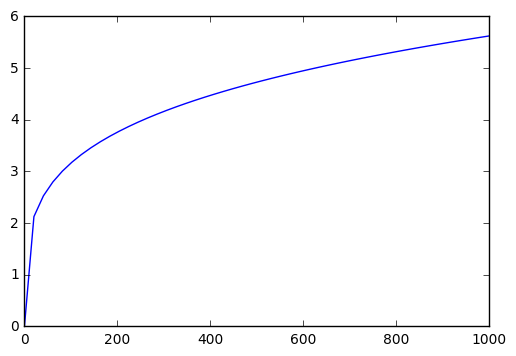

In [21]:
x = lins(0,1000)
y = list(map(lambda x:math.sqrt(math.sqrt(x)), x))
plot.plot(x,y)
plot.show()

In [239]:
# Debug Classifiers using k-Fold = 4
precision, recall, F1 = clf_train(setA, 'd', 4, verbose=True, get_feature=get_feature2, debug=False)
precision, recall, F1 = clf_train(setA, 'l', 4, verbose=True, get_feature=get_feature2, debug=False)
precision, recall, F1 = clf_train(setA, 'r', 4, verbose=True, get_feature=get_feature2, debug=False)
precision, recall, F1 = clf_train(setA, 's', 4, verbose=True, get_feature=get_feature2, debug=False)
precision, recall, F1 = clf_train(setA, 'n', 4, verbose=True, get_feature=get_feature2, debug=False)


DECISION TREE CLASSIFIER
Precision: 0.9357142857142857
Recall: 0.9436507936507936
F1: 0.9396103896103896

LOGISTIC REGRESSION CLASSIFIER
Precision: 0.8570315305609423
Recall: 0.9184071919366036
F1: 0.8841245546553295

RANDOM FOREST CLASSIFIER
Precision: 0.9609375
Recall: 0.9714285714285714
F1: 0.9636620441705188

SUPPORT VECTOR MACHING CLASSIFIER
Precision: 0.8588144935393512
Recall: 0.919183485359956
F1: 0.8867573345127525

NAIVE BAYES CLASSIFIER
Precision: 0.9406986662531018
Recall: 0.9301389786683903
F1: 0.9333326735025139


In [597]:
# Debug on only random forest
clf = ensemble.RandomForestClassifier(verbose=True, min_samples_split=0.15, min_samples_leaf=3, n_estimators=200)
train,test = setA[:225], setA[225:]
feature, label = get_feature2(train)
clf.fit(feature, label)
path_x = clf.feature_importances_
print("Random Forest weights")
# Result shows that weights are mostly place on "Title", "Director", "Rating", "Duration"
# "Title" "Category" "Rating" "Director" "Duration" "Rating Count"
print(path_x)
precision, recall, F1 = clf_test(test, clf, "Random Forest Test", get_feature=get_feature2, verbose=True)

Random Forest weights
[ 0.51426482  0.08735854  0.12159018  0.03214225  0.23341049  0.01123372]

RANDOM FOREST TEST
Precision: 0.9795918367346939
Recall: 0.9230769230769231
F1: 0.9504950495049506


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [606]:
# Final Classifier
clf = ensemble.RandomForestClassifier(min_samples_split=0.15, min_samples_leaf=3, n_estimators=200)
feature, label = get_feature2(setA)
clf = clf.fit(feature, label)
precision, recall, F1 = clf_test(setB, clf, "Final Classifier Evaluation(Random Forest)", get_feature=get_feature2, verbose=True)


FINAL CLASSIFIER EVALUATION(RANDOM FOREST)
Precision: 0.8823529411764706
Recall: 0.967741935483871
F1: 0.923076923076923
